<a href="https://colab.research.google.com/github/Ananthitha-Johnson/Time-Series-Stock-Forecasting/blob/main/Time_Series_Stock_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip -q install statsmodels scikit-learn tensorflow matplotlib pandas numpy

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras import layers

from statsmodels.tsa.arima.model import ARIMA

tf.random.set_seed(42)
np.random.seed(42)


In [3]:
url = "https://stooq.com/q/d/l/?s=aapl.us&i=d"  # Daily data
df = pd.read_csv(url)

df.head()


,Date,Open,High,Low,Close,Volume
0,1984-09-07,0.099605,0.100827,0.098402,0.099605,98811715
1,1984-09-10,0.099605,0.099910,0.097210,0.099014,76694011
2,1984-09-11,0.099910,0.102620,0.099910,0.100827,180849030
3,1984-09-12,0.100827,0.101417,0.097791,0.097791,157987052
4,1984-09-13,0.103232,0.103526,0.103232,0.103232,246058991


In [4]:
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date").reset_index(drop=True)

# Use Close price for forecasting
ts = df[["Date", "Close"]].dropna()

print(ts.shape)
ts.tail()


(10418, 2)


,Date,Close
10413,2026-01-07,260.33
10414,2026-01-08,259.04
10415,2026-01-09,259.37
10416,2026-01-12,260.25
10417,2026-01-13,261.05


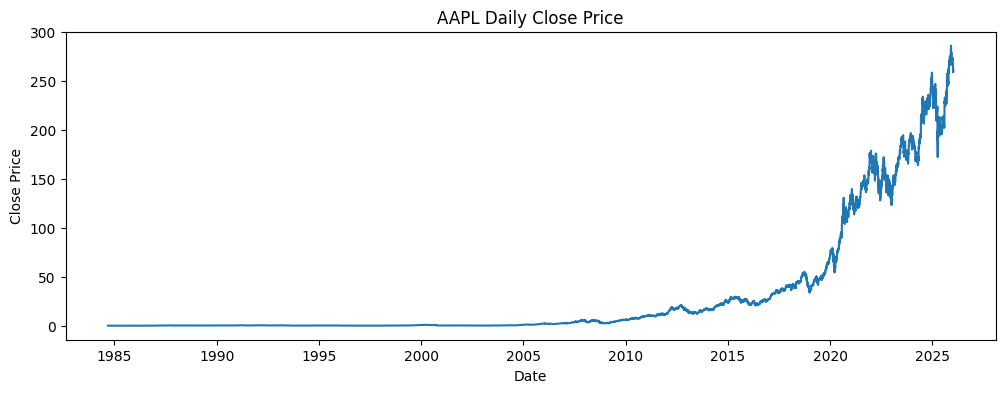

In [5]:
plt.figure(figsize=(12,4))
plt.plot(ts["Date"], ts["Close"])
plt.title("AAPL Daily Close Price")
plt.xlabel("Date"); plt.ylabel("Close Price")
plt.show()


In [6]:
split_idx = int(len(ts) * 0.8)
train = ts.iloc[:split_idx]
test  = ts.iloc[split_idx:]

train_close = train["Close"].values
test_close  = test["Close"].values

print("Train size:", len(train_close))
print("Test size :", len(test_close))


Train size: 8334
Test size : 2084


In [7]:
def regression_metrics(y_true, y_pred, name="Model"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print(f"{name} -> MAE: {mae:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.2f}%")
    return mae, rmse, mape


In [8]:
naive_pred = np.roll(test_close, 1)
naive_pred[0] = train_close[-1]  # first test prediction uses last train value

regression_metrics(test_close, naive_pred, "Naive Baseline")


Naive Baseline -> MAE: 1.6912, RMSE: 2.5885, MAPE: 1.33%


(1.6912017754318616,
 np.float64(2.5884766717227303),
 np.float64(1.3268433170192322))

In [9]:
model = ARIMA(train_close, order=(5,1,0))
arima_fit = model.fit()

arima_pred = arima_fit.forecast(steps=len(test_close))
regression_metrics(test_close, arima_pred, "ARIMA(5,1,0)")


ARIMA(5,1,0) -> MAE: 97.3231, RMSE: 118.9278, MAPE: 60.67%


(97.32310727311287,
 np.float64(118.9278058118769),
 np.float64(60.671784900490536))

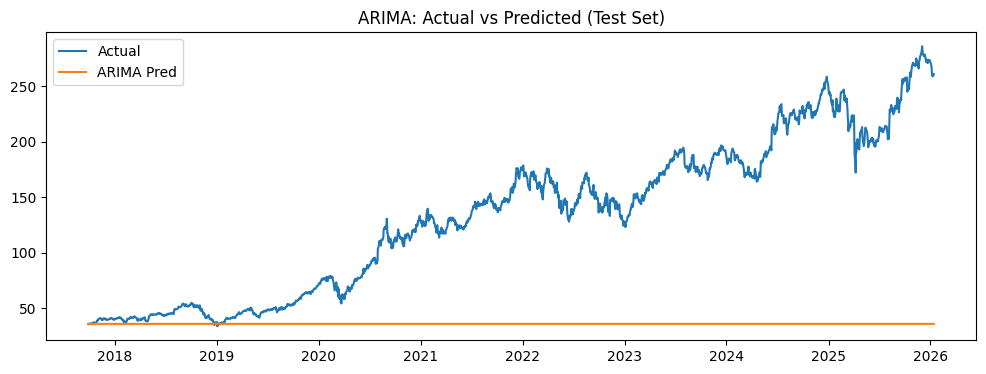

In [10]:
plt.figure(figsize=(12,4))
plt.plot(test["Date"], test_close, label="Actual")
plt.plot(test["Date"], arima_pred, label="ARIMA Pred")
plt.title("ARIMA: Actual vs Predicted (Test Set)")
plt.legend()
plt.show()


In [11]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_close.reshape(-1,1))
test_scaled  = scaler.transform(test_close.reshape(-1,1))

def make_sequences(data, lookback=60):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

LOOKBACK = 60
X_train, y_train = make_sequences(train_scaled, LOOKBACK)

# For test, we need to prepend last LOOKBACK points from train
combined = np.vstack([train_scaled[-LOOKBACK:], test_scaled])
X_test, y_test = make_sequences(combined, LOOKBACK)

X_train = X_train[..., np.newaxis]
X_test  = X_test[..., np.newaxis]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


(8274, 60, 1) (8274,) (2084, 60, 1) (2084,)


In [12]:
model_lstm = tf.keras.Sequential([
    layers.Input(shape=(LOOKBACK,1)),
    layers.LSTM(64, return_sequences=False),
    layers.Dense(32, activation="relu"),
    layers.Dense(1)
])

model_lstm.compile(optimizer="adam", loss="mse")

history = model_lstm.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=10,
    batch_size=32,
    verbose=1
)


Epoch 1/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.0021 - val_loss: 7.8686e-04
Epoch 2/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - loss: 2.5439e-05 - val_loss: 7.6048e-04
Epoch 3/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 2.2376e-05 - val_loss: 8.5057e-04
Epoch 4/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 2.0005e-05 - val_loss: 8.8382e-04
Epoch 5/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 1.8897e-05 - val_loss: 0.0012
Epoch 6/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 1.8245e-05 - val_loss: 0.0011
Epoch 7/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: 1.7548e-05 - val_loss: 0.0017
Epoch 8/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 1.7079e-05 - val_loss: 5.6408e-04
Epoch 9/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - loss: 1.8186e-05 - val_loss: 0.0011
Epoch 10/10
233/233 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - loss: 1.6900e-05 - val_loss: 8.2307e-04


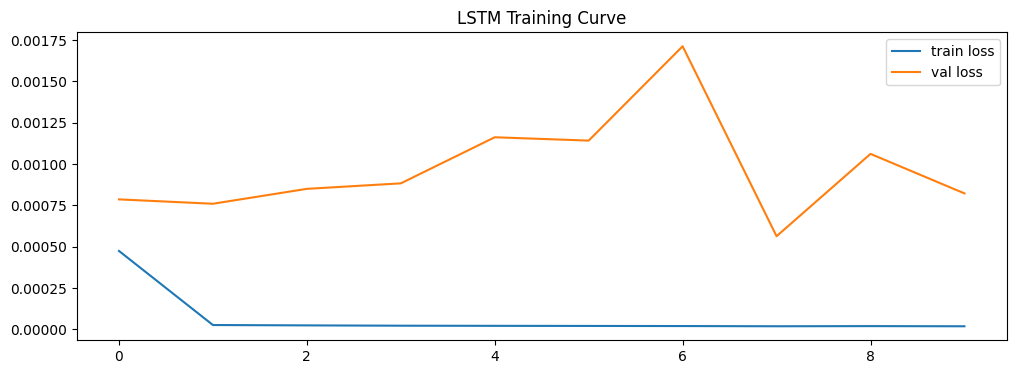

In [13]:
plt.figure(figsize=(12,4))
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.title("LSTM Training Curve")
plt.legend()
plt.show()


In [14]:
lstm_pred_scaled = model_lstm.predict(X_test).reshape(-1,1)
lstm_pred = scaler.inverse_transform(lstm_pred_scaled).reshape(-1)

# y_test is scaled, convert back:
y_test_actual = scaler.inverse_transform(y_test.reshape(-1,1)).reshape(-1)

regression_metrics(y_test_actual, lstm_pred, "LSTM")


66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
LSTM -> MAE: 44.5649, RMSE: 57.6084, MAPE: 26.56%


(44.56492310411157,
 np.float64(57.6084051818251),
 np.float64(26.562059356231078))

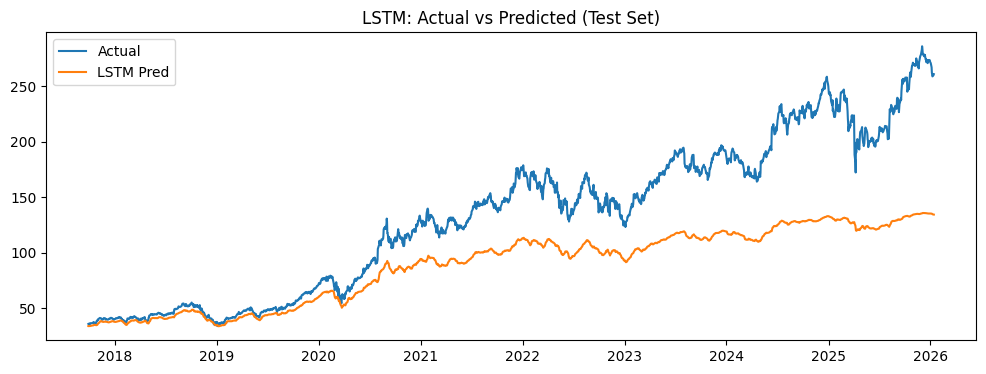

In [15]:
plt.figure(figsize=(12,4))
plt.plot(test["Date"].iloc[:len(lstm_pred)], y_test_actual, label="Actual")
plt.plot(test["Date"].iloc[:len(lstm_pred)], lstm_pred, label="LSTM Pred")
plt.title("LSTM: Actual vs Predicted (Test Set)")
plt.legend()
plt.show()


In [16]:
def forecast_next_days_lstm(model, last_values, days=30, lookback=60):
    # last_values: original scale close prices (1D)
    seq = scaler.transform(np.array(last_values).reshape(-1,1)).reshape(-1)
    preds = []
    for _ in range(days):
        x = seq[-lookback:].reshape(1, lookback, 1)
        pred_scaled = model.predict(x, verbose=0)[0,0]
        seq = np.append(seq, pred_scaled)
        pred = scaler.inverse_transform([[pred_scaled]])[0,0]
        preds.append(pred)
    return np.array(preds)

last_window = ts["Close"].values[-LOOKBACK:]
future_30 = forecast_next_days_lstm(model_lstm, last_window, days=30, lookback=LOOKBACK)

future_dates = pd.date_range(ts["Date"].iloc[-1] + pd.Timedelta(days=1), periods=30, freq="D")


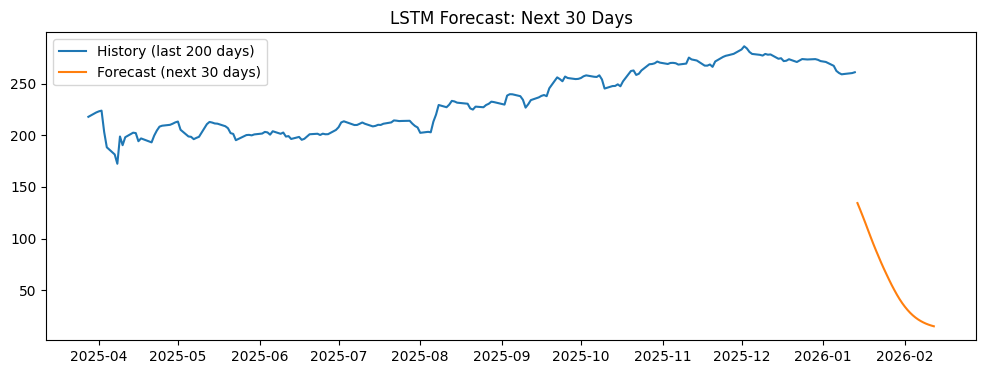

array([134.39851955, 128.18496199, 121.72867055, 115.1483832 ,
       108.36218583, 101.63440187,  95.06225289,  88.76985368,
        82.73582501,  76.72684698])

In [17]:
plt.figure(figsize=(12,4))
plt.plot(ts["Date"].iloc[-200:], ts["Close"].iloc[-200:], label="History (last 200 days)")
plt.plot(future_dates, future_30, label="Forecast (next 30 days)")
plt.title("LSTM Forecast: Next 30 Days")
plt.legend()
plt.show()

future_30[:10]